In [11]:
from __future__ import annotations
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm
import gymnasium as gym

env = gym.make("Blackjack-v1", sab=True)

done = False
observation, info = env.reset()

action = env.action_space.sample()
observation, reward, terminated, truncated, info = env.step(action)


In [12]:
class BlackjackAgent():
    def __init__(self, env, learning_rate: float, initial_episolon: float, epsilon_decay: float, final_epsilon: float, discount_factor: float = 0.95,):

        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
        self.lr = learning_rate
        self.discont_factor = discount_factor
        self.epsilon = initial_episolon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.training_error = []

    def get_action(self, env, obs: tuple[int, int, bool]) -> int:

        if np.random.random() < self.epsilon:
            return env.action_space.sample()
        
        else:
            return int(np.argmax(self.q_values[obs]))
        
    def update(self, obs: tuple[int, int, bool], action: int, reward: float, terminated: bool, next_obs: tuple[int, int, bool],):
        
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_diference = (reward + self.discont_factor * future_q_value - self.q_values[obs][action])
        self.q_values[obs][action] = (self.q_values[obs][action] + self.lr * temporal_diference)
        self.training_error.append(temporal_diference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)
        

In [13]:
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)
final_epsilon = 0.1

agent = BlackjackAgent(env=env, learning_rate=learning_rate, initial_episolon=start_epsilon, epsilon_decay=epsilon_decay, final_epsilon=final_epsilon)


In [14]:
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.get_action(env, obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        agent.update(obs, action, reward, terminated, next_obs)
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()    

100%|██████████| 100000/100000 [00:08<00:00, 11923.69it/s]


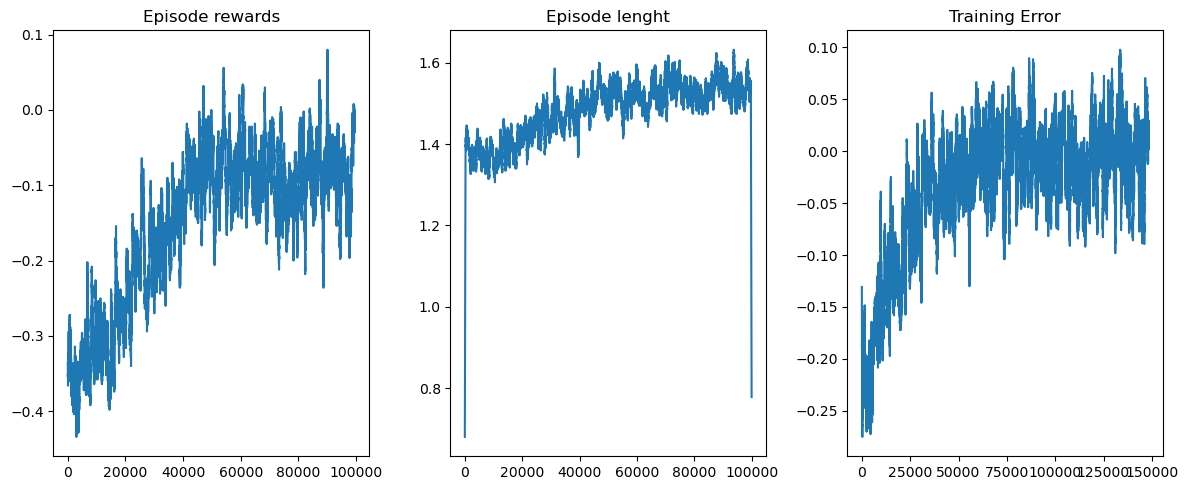

In [15]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
reward_moving_averange = (np.convolve(np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid") / rolling_length)
axs[0].plot(range(len(reward_moving_averange)), reward_moving_averange)

axs[1].set_title("Episode lenght")
length_moving_averange = (np.convolve(np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same") / rolling_length)
axs[1].plot(range(len(length_moving_averange)), length_moving_averange)

axs[2].set_title("Training Error")
training_error_averange = (np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same") / rolling_length)
axs[2].plot(range(len(training_error_averange)), training_error_averange)

plt.tight_layout()
plt.show()

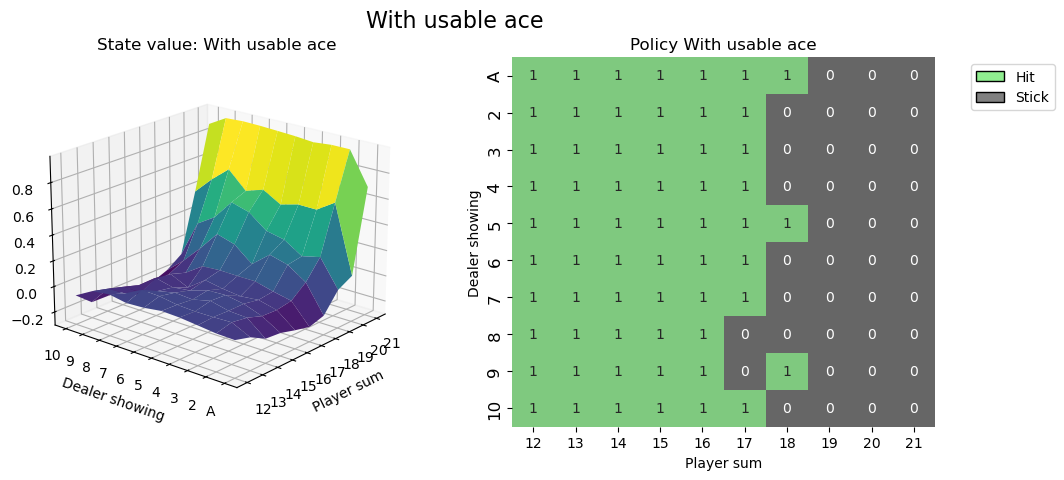

In [16]:
def create_grids(agent, usable_ace=False):

    state_value = defaultdict(float)
    policy = defaultdict(int)

    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(np.arange(12, 22), np.arange(1, 11),)
    value = np.apply_along_axis(lambda obs: state_value[(obs[0], obs[1], usable_ace)], axis=2, arr=np.dstack([player_count, dealer_count]),)
    value_grid = player_count, dealer_count, value
    policy_grid = np.apply_along_axis(lambda obs: policy[(obs[0], obs[1], usable_ace)], axis=2, arr=np.dstack([player_count, dealer_count]),)

    return value_grid, policy_grid

def create_plots(value_grid, policy_grid, title: str):
    
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(player_count, dealer_count, value, rstride=1, cstride=1, cmap="viridis", edgecolor="none",)
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State value: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidths=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    legend_elements = [Patch(facecolor="lightgreen", edgecolor="black", label="Hit"), Patch(facecolor="grey", edgecolor="black", label="Stick"),]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    
    return fig

value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()
